In [7]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import ast
from sklearn.model_selection import GridSearchCV

In [8]:
# Data cleaning
# convert song attributes to numeric values
df = pd.read_csv('SongCSV.csv')

columns_to_convert = ['Acousticness', 'Danceability', 'Duration', 'Key', 'Energy', 'Instrumentalness',
                      'Liveness', 'Loudness', 'Speechiness', 'Tempo', 'Mode', 'Time Signature']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# remove Split column
def drop_column(row, column_name):
    return row.drop(column_name)

df = df.apply(lambda row: drop_column(row, 'Split'), axis=1)


In [9]:
# Data claeaning
# Condense artist features with multiple artist names to the main artist
df['Artist'] = df['Artist'].apply(lambda x: x.split(',')[0] if isinstance(x, str) else x)

# Drop duplicate items
df = df.drop_duplicates()

# convert to seconds instead of miliseconds
df['Duration'] = df['Duration'] / 1000

In [10]:
# Data cleaning 
# Condense genres into the artist's primary genre
def extract_first_genre(x):
    if isinstance(x, str):
        try:
            genre_list = ast.literal_eval(x)
            if isinstance(genre_list, list) and len(genre_list) > 0:
                return genre_list[len(genre_list) - 1]
        except ValueError:
            pass
    return None

df['Genres'] = df['Genres'].apply(extract_first_genre)

In [11]:
# Data Cleaning
# Initialize data frames and organize grammy data frames into one dataframe
billboard_df = pd.read_csv('charts.csv')

grammy1_df = pd.read_csv('grammySongs_1999-2019.csv')
grammy2_df = pd.read_csv('grammysTo2014.csv')
grammy_df = pd.DataFrame(columns=['Year', 'Song', 'Artist'])
i = 0

# grammy 1
for index, row in grammy1_df.iterrows():
    year = row['GrammyYear']
    song_name = row['Name']
    artist = row['Artist']
    
    if 2014 <= int(year) <= 2021:
        grammy_df.loc[i] = {'Year': int(year), 'Song': song_name, 'Artist': artist}
        i = i + 1

# grammy 2
for index, row in grammy2_df.iterrows():
    year = row['Year']
    song_name = row['Title']
    artist = row['Winners']
    
    if int(year) < 2014:
        grammy_df.loc[i] = {'Year': int(year), 'Song': song_name, 'Artist': artist}
        i = i + 1

grammy_df = grammy_df.sort_values(by='Year', ascending=False)

# drop values that are NaN
grammy_df = grammy_df.dropna()
billboard_df = billboard_df.dropna()

In [12]:
# Preprocessing
# Check to see if each song has been on the billboard or has won a grammy
df = df[df['Year'] <= '2021']

for index, row in df.iterrows():
    hit = False
    if row['Song'].upper() in grammy_df['Song'].str.upper().tolist():
        hit = True
    if not hit:
        if row['Song'].upper() in billboard_df['song'].str.upper().tolist():
            hit = True
    df.loc[index, 'Hit'] = int(1) if hit else int(0)
num_hits = df['Hit'].value_counts().get(1, 0)
print(f"Number of hits: {num_hits}")


In [ ]:
# Preprocessing
# Convert continuous values to discrete values 
features = ['Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
                      'Liveness', 'Loudness', 'Speechiness']
bins = 100
for i in range(len(features)): 
    kbins = KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')
    df[features[i]] = kbins.fit_transform(df[[features[i]]])
    df[features[i]] = pd.to_numeric(df[features[i]], errors='coerce').astype(int)

# Turn features to integers/discrete values
df['Tempo'] = pd.to_numeric(df['Tempo'], errors='coerce').astype(int)
df['Duration'] = pd.to_numeric(df['Duration'], errors='coerce').astype(int)
df['Key'] = pd.to_numeric(df['Key'], errors='coerce').astype(int)
df['Mode'] = pd.to_numeric(df['Mode'], errors='coerce').astype(int)
df['Time Signature'] = pd.to_numeric(df['Time Signature'], errors='coerce').astype(int)

/Users/carsonnannini/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/carsonnannini/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/carsonnannini/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
/Users/carsonnannini/a

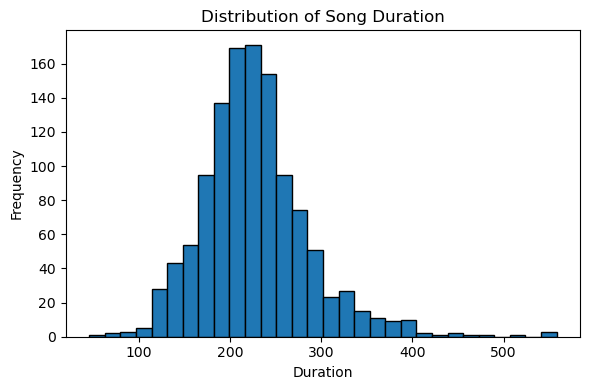

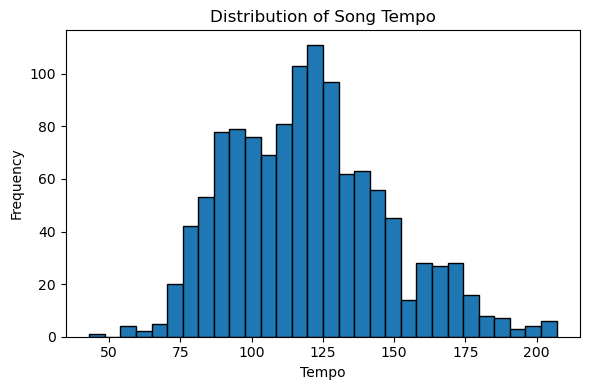

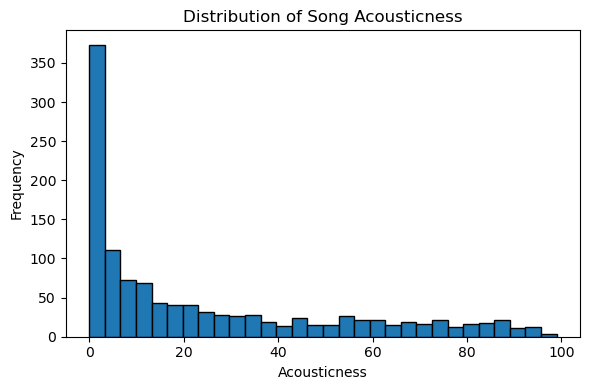

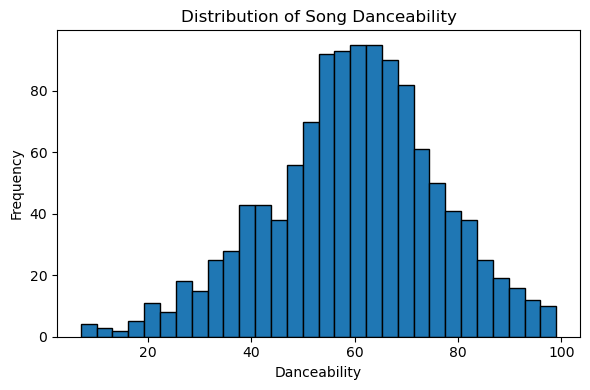

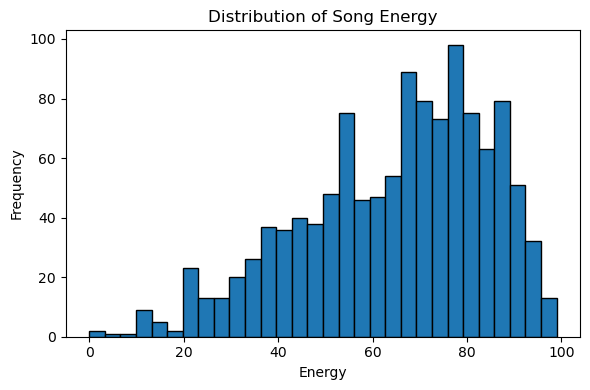

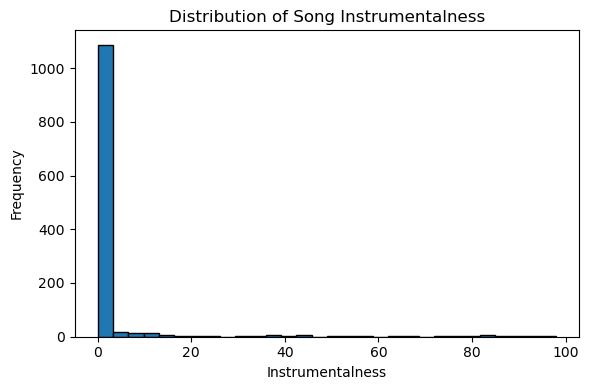

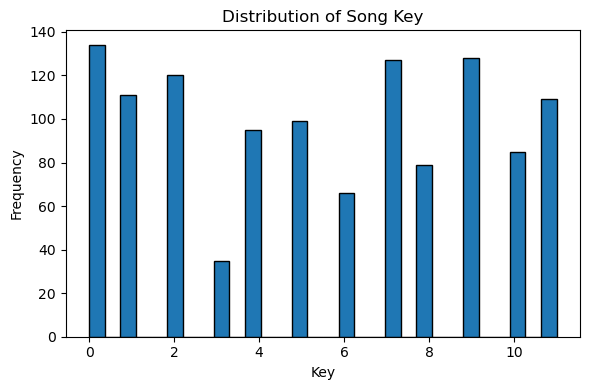

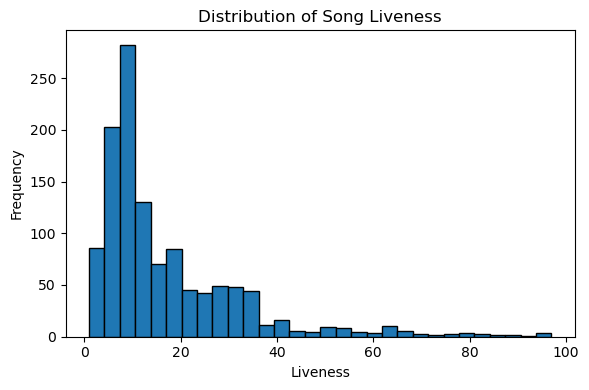

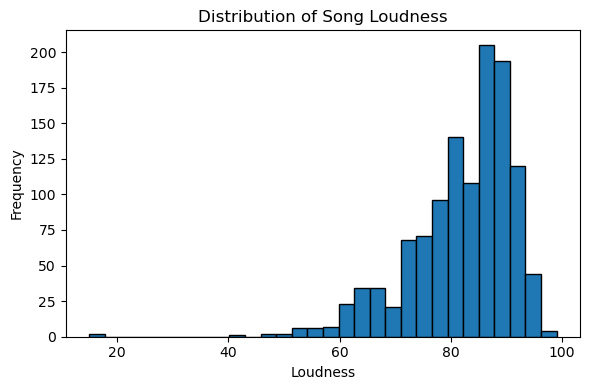

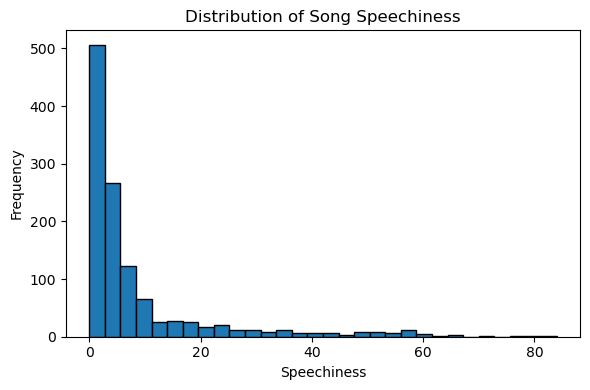

In [ ]:
# Data Visualization 
# Show histogram of each feature 
# Helps determine most common and most popular traits amoung hit songs 
hit_df = df[df['Hit'] == 1].reset_index(drop=True)
feature_list = ['Duration', 'Tempo', 'Acousticness', 'Danceability', 'Energy', 'Instrumentalness', 'Key',
                'Liveness', 'Loudness', 'Speechiness']

for feature in feature_list:
    plt.figure(figsize=(6, 4))
    plt.hist(hit_df[feature], bins=30, edgecolor='black') 
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title(f'Distribution of Song {feature}')
    plt.tight_layout()
    plt.show()


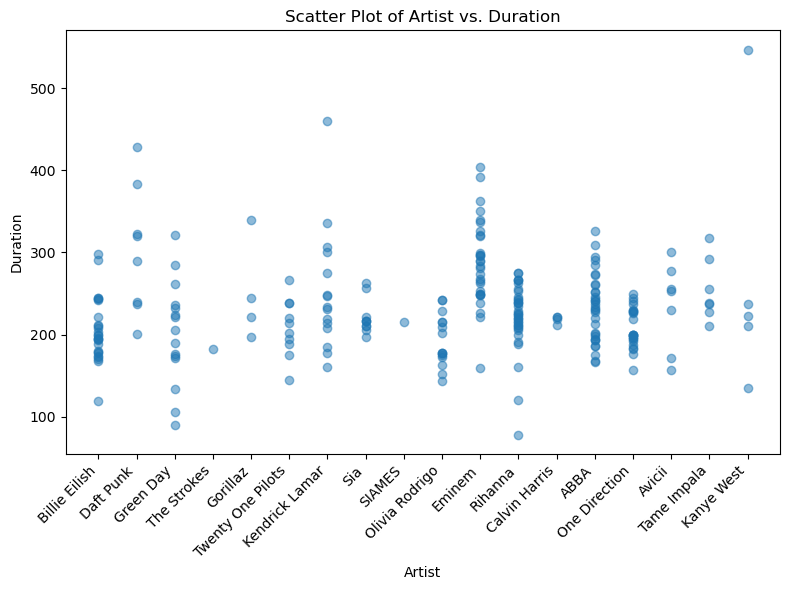

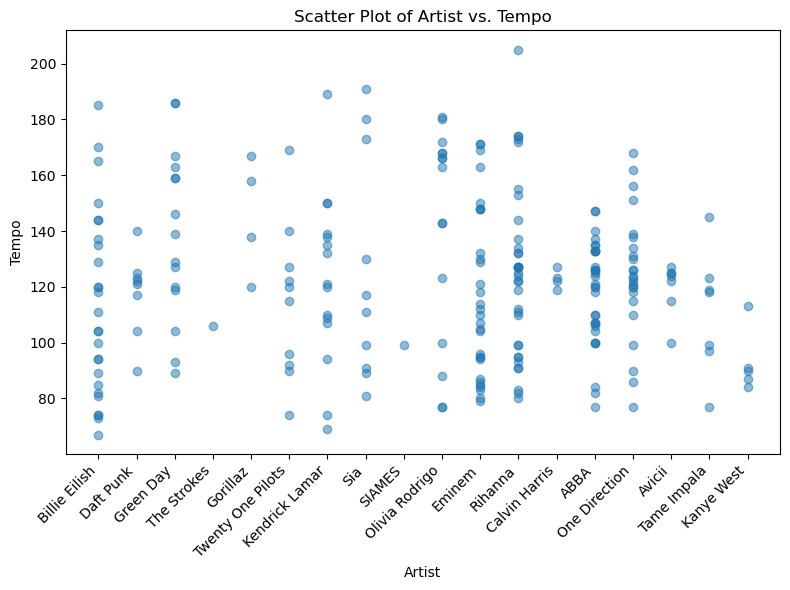

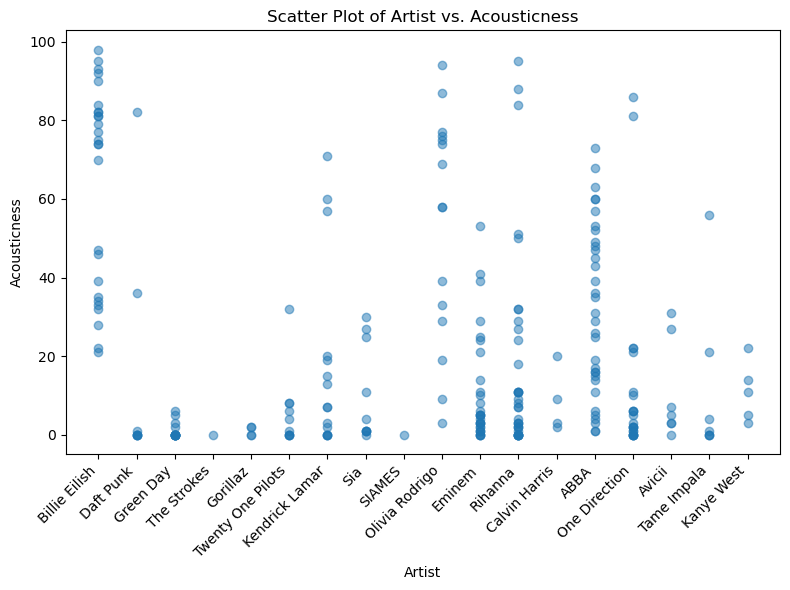

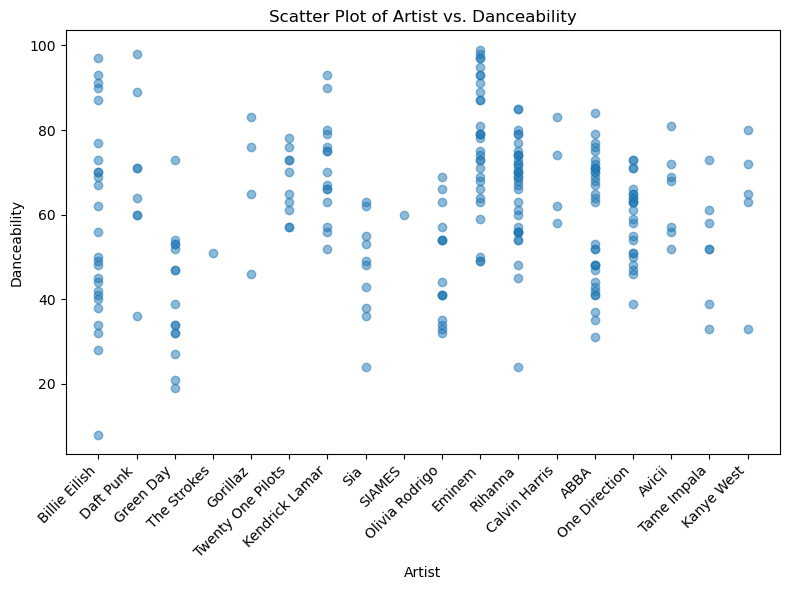

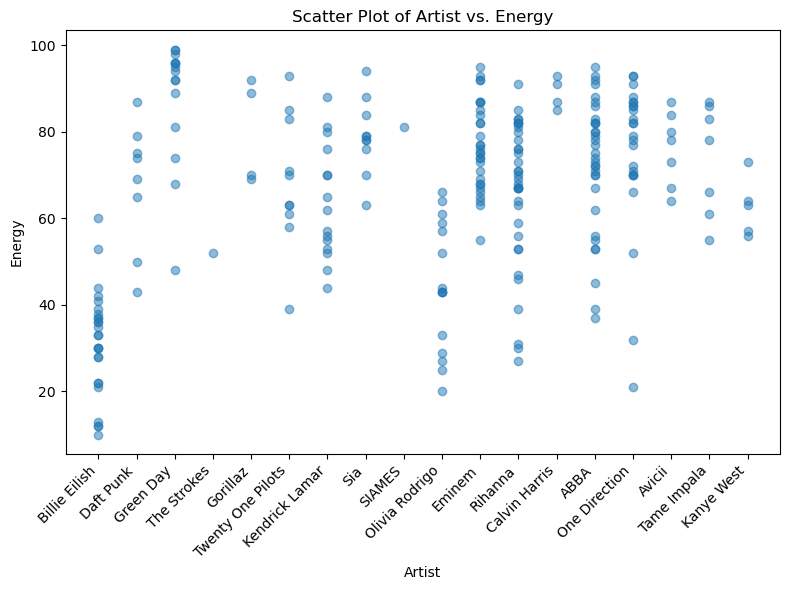

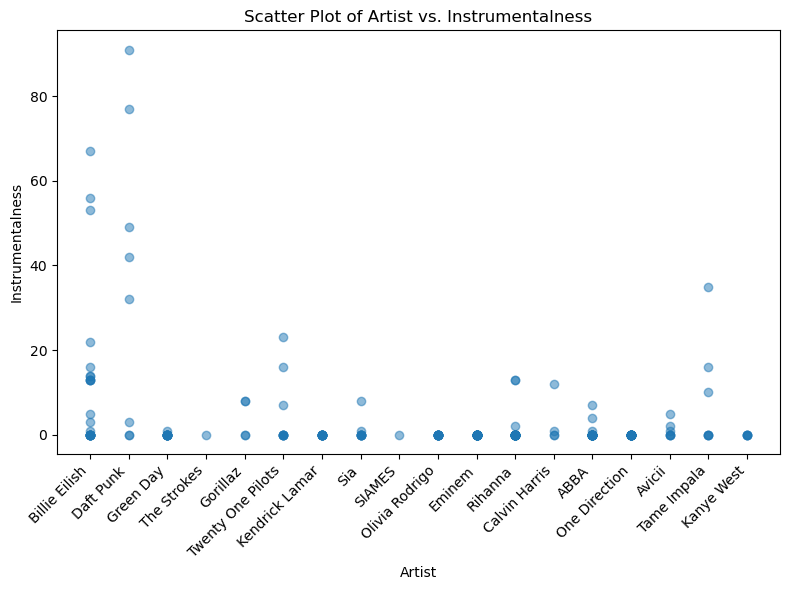

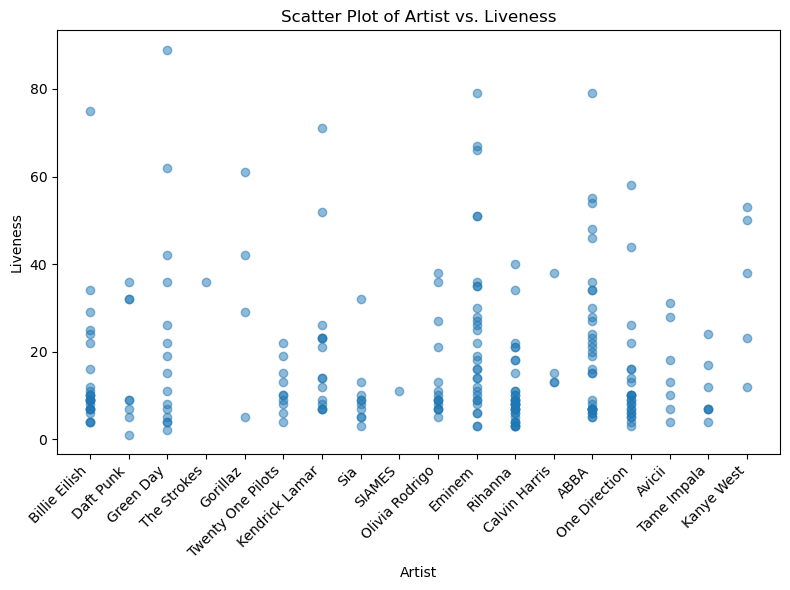

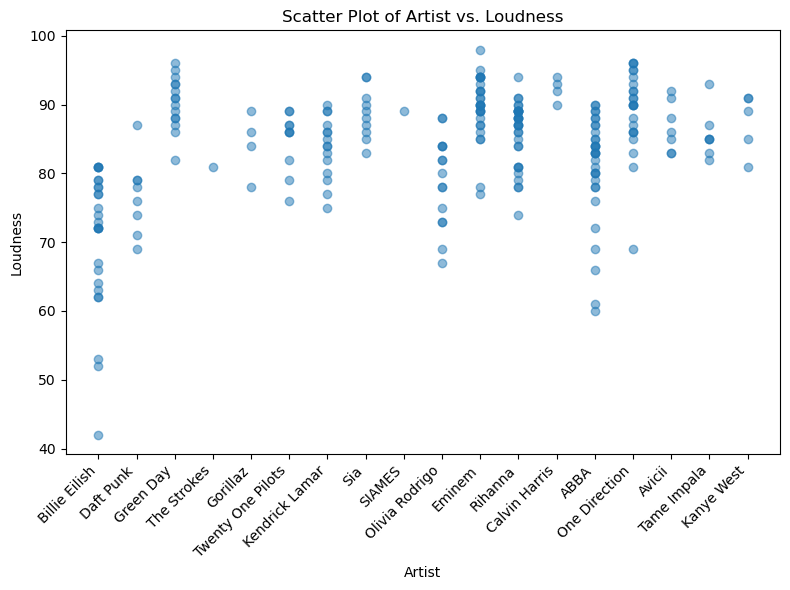

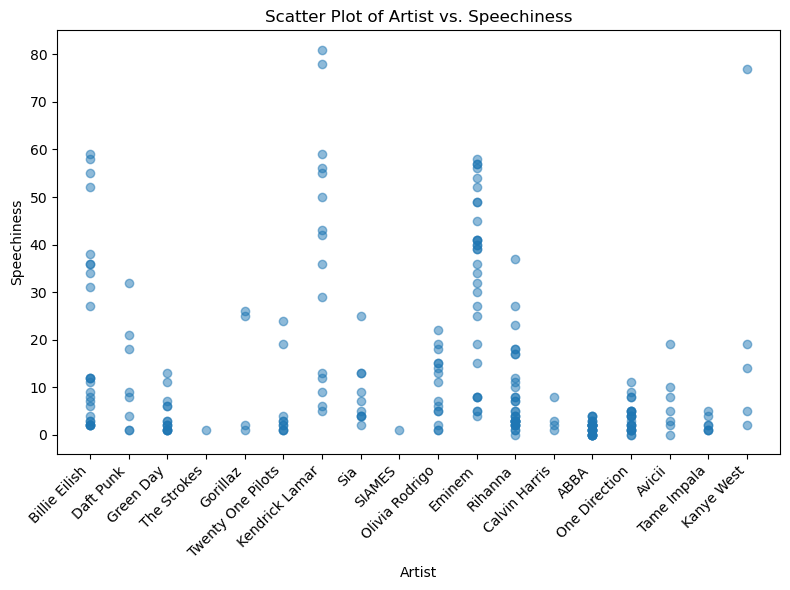

In [ ]:
# Data visualization
# Find patterns or 'signatures' for attributes in different artist's hit songs
feature_list = ['Duration', 'Tempo', 'Acousticness', 'Danceability', 'Energy', 'Instrumentalness',
                'Liveness', 'Loudness', 'Speechiness']
for feature in feature_list:
    sub_hit = hit_df.head(250)
    X = sub_hit
    plt.figure(figsize=(8, 6))
    plt.scatter(X['Artist'], X[feature], alpha=0.5)
    plt.xlabel('Artist')
    plt.ylabel(feature)
    plt.title(f'Scatter Plot of Artist vs. {feature}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    plt.show()

/var/folders/97/sr1hg5zs2lb7yw9x11fk2tbm0000gn/T/ipykernel_15683/4021288777.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df_sampled = hit_df.groupby('Year').apply(lambda x: x.sample(n=min(len(x), iinstances_per_year))).reset_index(drop=True)


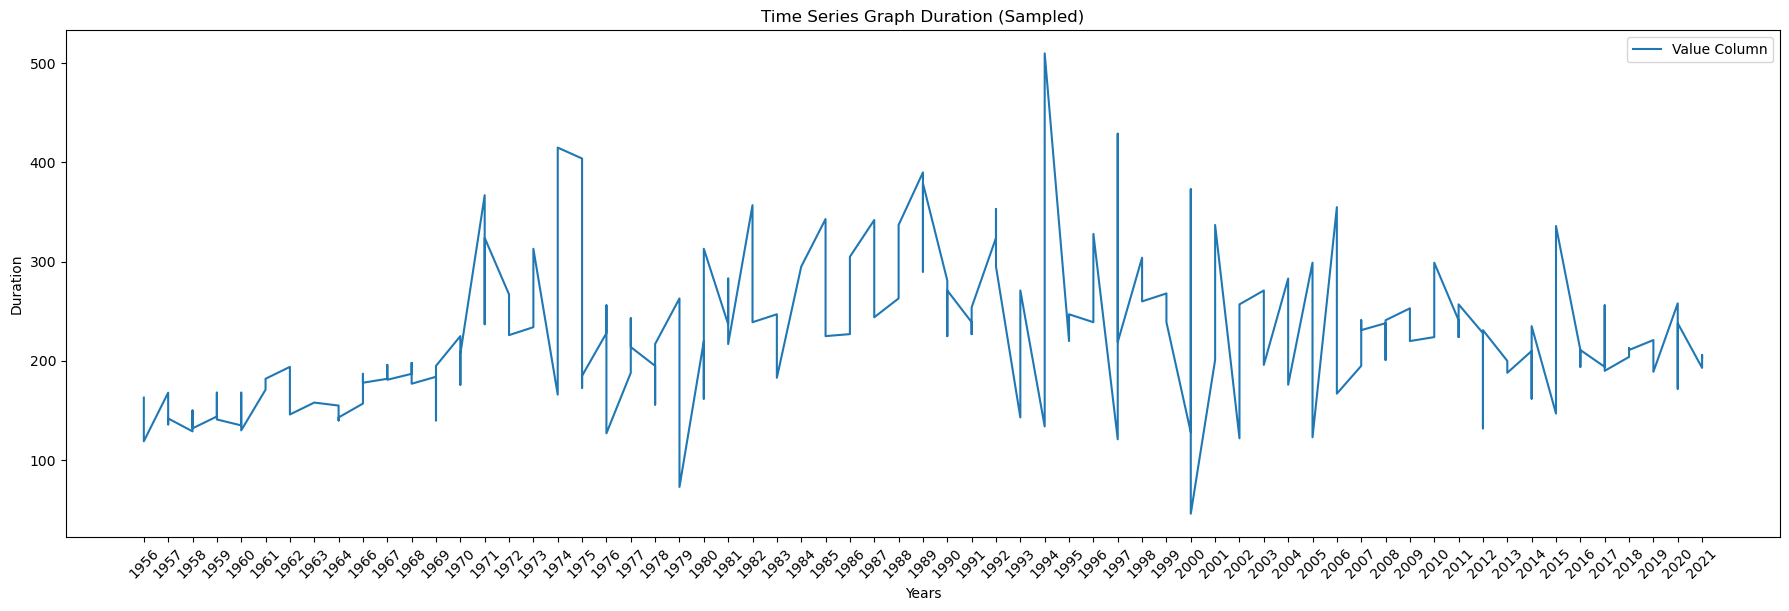

/var/folders/97/sr1hg5zs2lb7yw9x11fk2tbm0000gn/T/ipykernel_15683/4021288777.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df_sampled = hit_df.groupby('Year').apply(lambda x: x.sample(n=min(len(x), iinstances_per_year))).reset_index(drop=True)


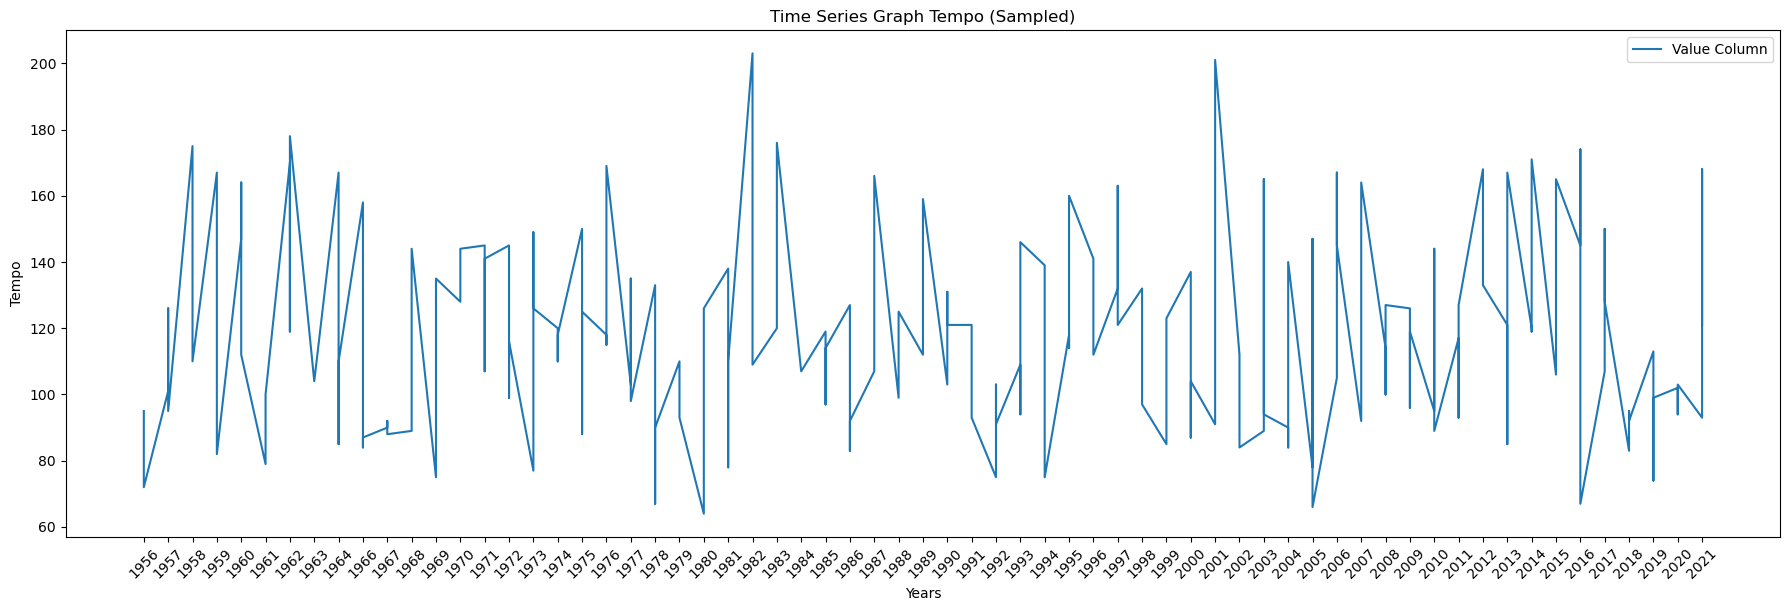

/var/folders/97/sr1hg5zs2lb7yw9x11fk2tbm0000gn/T/ipykernel_15683/4021288777.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df_sampled = hit_df.groupby('Year').apply(lambda x: x.sample(n=min(len(x), iinstances_per_year))).reset_index(drop=True)


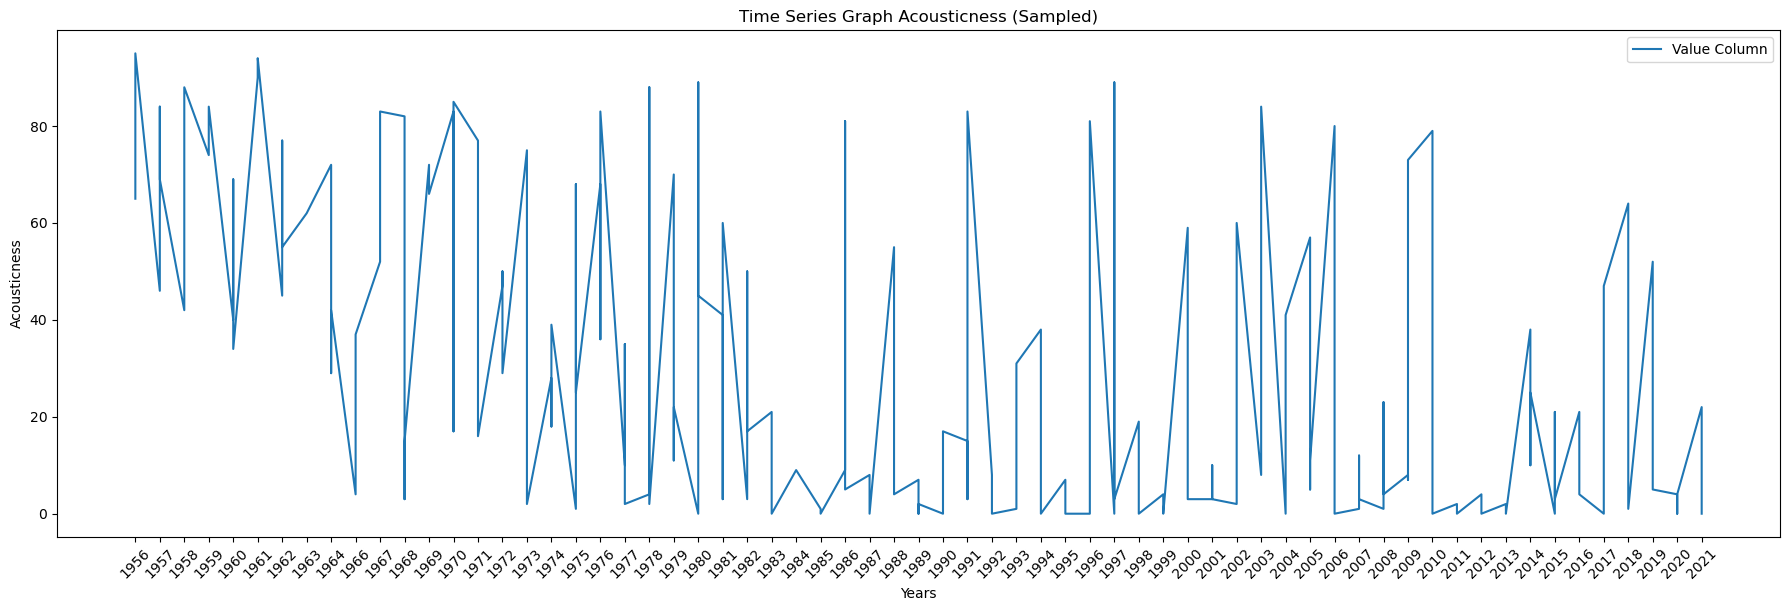

/var/folders/97/sr1hg5zs2lb7yw9x11fk2tbm0000gn/T/ipykernel_15683/4021288777.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  hit_df_sampled = hit_df.groupby('Year').apply(lambda x: x.sample(n=min(len(x), iinstances_per_year))).reset_index(drop=True)


In [ ]:

# Data Visualization 
# Show changes in different song features over the years
for feature in feature_list:
    iinstances_per_year = 3
    hit_df_sampled = hit_df.groupby('Year').apply(lambda x: x.sample(n=min(len(x), iinstances_per_year))).reset_index(drop=True)

    plt.figure(figsize=(18, 6))
    plt.plot(hit_df_sampled['Year'], hit_df_sampled[feature], label='Value Column')
    plt.xlabel('Years')
    plt.ylabel(feature)
    plt.title(f'Time Series Graph {feature} (Sampled)')
    plt.legend()
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

In [ ]:
# Split df into train and test data sets
# Train on Hit column
X = df.drop(columns=['Hit'])
Y = df['Hit']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

In [ ]:
# Preprocessing 
# Used to give numeric values to non numeric types
def label_encoder(data):
    le = LabelEncoder()
    data['Song'] = le.fit_transform(data['Song'])
    data['Artist'] = le.fit_transform(data['Artist'])
    data['Genres'] = le.fit_transform(data['Genres'])
    return data

In [ ]:
# Preprocessing
X_train = label_encoder(X_train)
X_test = label_encoder(X_test)


In [ ]:
# Data Modeling
# Find the best alpha to use for model
def get_alpha(x_train):
    alphas = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0]
    param_grid = {'alpha': alphas}
    lasso = Lasso(random_state=42)
    grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=5)
    grid_search.fit(x_train, Y_train)
    best_alpha = grid_search.best_params_['alpha']
    return best_alpha

# Apply LASSO model
def get_lasso(x_train, alpha):
    lasso = Lasso(alpha=alpha, random_state=42)
    lasso.fit(x_train, Y_train)
    return lasso

lasso = get_lasso(X_train, get_alpha(X_train)


SyntaxError: incomplete input (3615591104.py, line 18)

In [ ]:
# Data Modeling
# Apply random forest model
def get_randFor(x_train):
    random_forest = RandomForestClassifier(n_estimators=10, random_state=0, n_jobs=-1)  
    random_forest.fit(x_train, Y_train)
    return random_forest

random_forest = get_randFor(X_train)

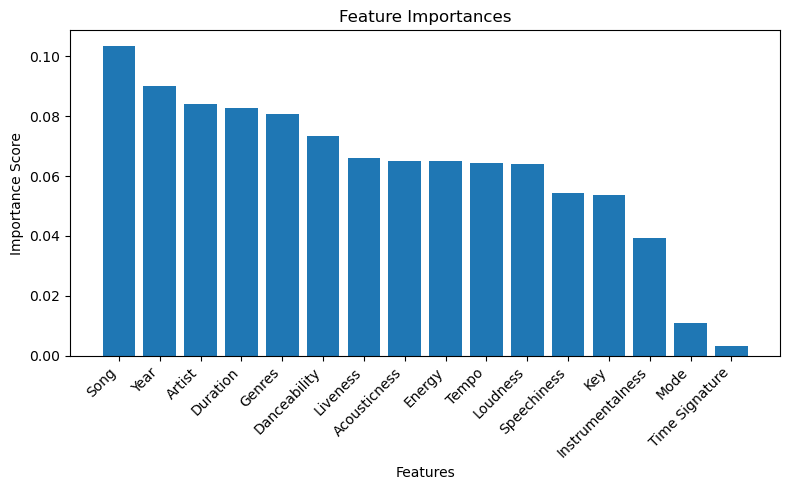

In [ ]:
# Use the random forest model to determine most important features for predicting popularity
feature_importances = random_forest.feature_importances_

importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 5))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.title('Feature Importances')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Data Modeling
# Apply decision tree model
def get_decision_tree(x_train):
    decision_tree = DecisionTreeClassifier(random_state=42)
    decision_tree.fit(x_train, Y_train)
    return decision_tree
decision_tree = get_decision_tree(X_train)

In [ ]:
# Results
# Get classification result for each model
lasso_pred = lasso.predict(X_test)
random_forest_pred = random_forest.predict(X_test)
decision_tree_pred = decision_tree.predict(X_test)
threshold = 0.4
lasso_pred_binary = (lasso_pred > threshold).astype(int)
random_forest_pred_binary = (random_forest_pred > threshold).astype(int)
decision_tree_pred_binary = (decision_tree_pred > threshold).astype(int)

models = ['lasso', 'random forest', 'decision tree']
preds_class_binary = [lasso_pred_binary, random_forest_pred_binary, decision_tree_pred_binary]
for i, model in enumerate(models):
    print(f"Classification Report: {model}:\n{classification_report(Y_test, preds_class_binary[i])}")

Classification Report: lasso:
              precision    recall  f1-score   support

         0.0       0.66      0.58      0.62       558
         1.0       0.44      0.52      0.48       354

    accuracy                           0.56       912
   macro avg       0.55      0.55      0.55       912
weighted avg       0.57      0.56      0.56       912

Classification Report: random forest:
              precision    recall  f1-score   support

         0.0       0.67      0.87      0.76       558
         1.0       0.61      0.33      0.43       354

    accuracy                           0.66       912
   macro avg       0.64      0.60      0.59       912
weighted avg       0.65      0.66      0.63       912

Classification Report: decision tree:
              precision    recall  f1-score   support

         0.0       0.64      0.67      0.66       558
         1.0       0.44      0.42      0.43       354

    accuracy                           0.57       912
   macro avg       0.5